In [1]:
import matplotlib 
%matplotlib inline

from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 12]


import numpy as np
import pandas as pd

N = 8
d = 4
dates = np.linspace(0, d)


In [2]:
paths = np.array([
    [1, 1.09, 1.08, 1.34],
    [1, 1.16, 1.26, 1.54],
    [1, 1.22, 1.07, 1.03],
    [1, 0.93, 0.97, 0.92],
    [1, 1.11, 1.56, 1.52],
    [1, 0.76, 0.77, 0.90],
    [1, 0.92, 0.84, 1.01],
    [1, 0.88, 1.22, 1.34],
])

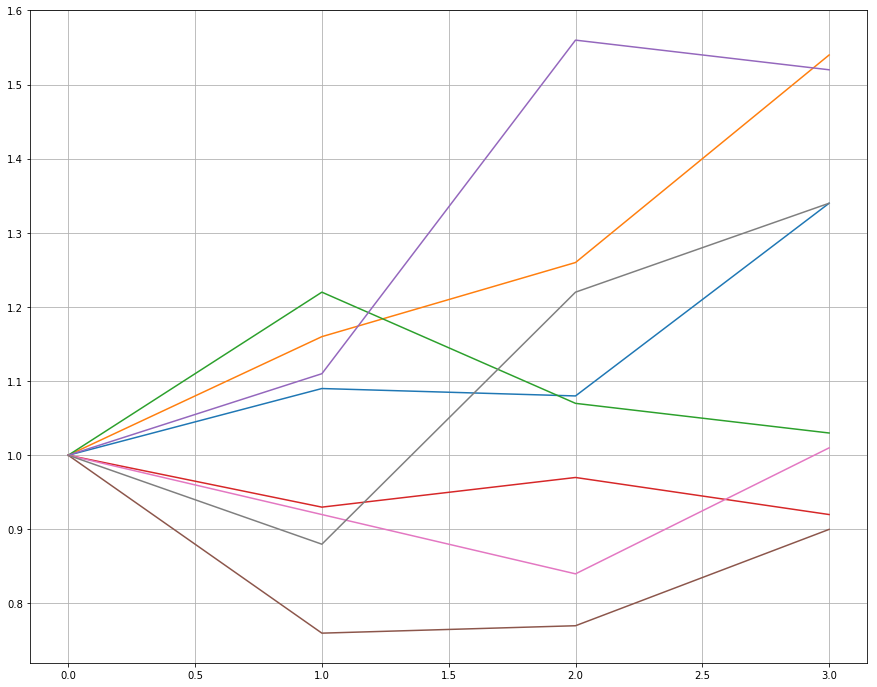

In [3]:
plt.plot(paths.T)  # dates should be the X 
plt.grid()

In [4]:
# let payoff be a put with strike = 1.1

def payoff(spot, strike=1.1):
    diff = strike - spot
    return np.clip(diff, a_min=0, a_max=None)

In [5]:
# terminal value: on last day 3

cfs = payoff(paths[:, -1])
cfs

array([0.  , 0.  , 0.07, 0.18, 0.  , 0.2 , 0.09, 0.  ])

In [6]:
conditional_cashflows = np.zeros(paths.shape)
# set last column to terminal values. 
conditional_cashflows[:, -1] = cfs

r = 0.06
df = 0.94176
strike = 1.1
# Today is day 2. Find paths for which payoff is ITM
today_cfs = payoff(paths[:, -2])
today_itm = np.nonzero(today_cfs>0)[0]
# the y values are discounted tomorrow's values for which paths we exercised today
outs = cfs[today_itm] * df
ins = paths[:, -2][today_itm]

coeffs = np.polyfit(ins, outs, 2)  # fit second degree.
cont_vals = (coeffs[None, :] * np.vander(ins, 3)).sum(axis=1)
cont_vals2 = np.polynomial.polynomial.polyval(ins[None, :], coeffs[::-1], tensor=True)

In [7]:
today_itm

array([0, 2, 3, 5, 6])

In [8]:
ins

array([1.08, 1.07, 0.97, 0.77, 0.84])

In [9]:
outs/df

array([0.  , 0.07, 0.18, 0.2 , 0.09])

In [10]:
0.07*0.94176

0.06592320000000002

In [11]:
coeffs

array([-1.81356745,  2.98339626, -1.0699825 ])

In [12]:
cont_vals

array([0.03674038, 0.04589812, 0.11752626, 0.15196848, 0.15641716])

In [13]:
cont_vals2

array([[0.03674038, 0.04589812, 0.11752626, 0.15196848, 0.15641716]])

In [14]:
exercise_vals = strike - ins
exercise_vals

array([0.02, 0.03, 0.13, 0.33, 0.26])

In [15]:
exercise_today = np.nonzero(exercise_vals > cont_vals)[0]

# set values in conditional_cashflows.
conditional_cashflows[:, -1][today_itm[exercise_today]] = 0
conditional_cashflows[:, -2][today_itm[exercise_today]] = exercise_vals[exercise_today]

In [16]:
conditional_cashflows

array([[0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.07],
       [0.  , 0.  , 0.13, 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.33, 0.  ],
       [0.  , 0.  , 0.26, 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])

In [17]:
# Now put it into a function. 
df = 0.94176

def dump(stmt, debug=True):
    if debug:
        print(stmt)

def backward_induction(paths, strike=1.1, df=df, payoff_fn=payoff, debug=True):
    realised_cashflows = np.zeros(paths.shape)
    # set last column to terminal values. 
    realised_cashflows[:, -1] = payoff(paths[:, -1])
    ndt = paths.shape[1]
    dump('ndt={}'.format(ndt), debug)
    # For a simple American option, we only have to iterate over the time points
    # If we were doing storage/swing we would have to iterate over the possible actions
    for idx in np.arange(ndt-1, 1, step=-1):
        dump('\n\nt={} ---------------------------------'.format(idx-1), debug)
        cfs = payoff_fn(paths[:, idx])
        # Find paths for which today, payoff is ITM
        today_cfs = payoff_fn(paths[:, idx-1])
        dump('today cfs: {}'.format(today_cfs), debug)
        today_itm = np.nonzero(today_cfs>0)[0]
        dump('ITM for paths: {}'.format(today_itm), debug)
        # the y values are discounted tomorrow's values for which paths we exercised today
        # but note, we have to use the realised cashflows NOT the theoretical ones
        # based only on the prices. That means even if the price says we should
        # exercise today, if a future decision has said we do not exercise then 
        # the future realised cashflow is 0. 
        # the PV will otherwise be biased high. 
        regr_out = realised_cashflows[:, idx][today_itm] * df
        dump('Y: next step cfs: {}'.format(regr_out/df), debug)
        regr_in = paths[:, idx-1][today_itm]
        dump('X: today prices: {}'.format(regr_in), debug)
        coeffs = np.polyfit(regr_in, regr_out, 2)  # fit second degree.
        dump('today coeffs: {}'.format(coeffs), debug)
        # Note the continuation values are only used for comparison
        # with today's exercise. 
        cont_vals = np.polynomial.polynomial.polyval(regr_in, coeffs[::-1], tensor=True)
        dump('continuation vals: {}'.format(cont_vals), debug)
        # Exercise values will form the realised cashflows for the next iteration
        exercise_vals = payoff_fn(regr_in, strike)
        dump('if exercise today: {}'.format(exercise_vals), debug)
        exercise_today = np.nonzero(exercise_vals > cont_vals)[0]
        # set values in realised_cashflows.
        realised_cashflows[:, idx][today_itm[exercise_today]] = 0
        realised_cashflows[:, idx-1][today_itm[exercise_today]] = exercise_vals[exercise_today]

        print(realised_cashflows)
    return realised_cashflows
    

In [18]:
out = backward_induction(paths)

ndt=4


t=2 ---------------------------------
today cfs: [0.02 0.   0.03 0.13 0.   0.33 0.26 0.  ]
ITM for paths: [0 2 3 5 6]
Y: next step cfs: [0.   0.07 0.18 0.2  0.09]
X: today prices: [1.08 1.07 0.97 0.77 0.84]
today coeffs: [-1.81356745  2.98339626 -1.0699825 ]
continuation vals: [0.03674038 0.04589812 0.11752626 0.15196848 0.15641716]
if exercise today: [0.02 0.03 0.13 0.33 0.26]
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.07]
 [0.   0.   0.13 0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.33 0.  ]
 [0.   0.   0.26 0.  ]
 [0.   0.   0.   0.  ]]


t=1 ---------------------------------
today cfs: [0.01 0.   0.   0.17 0.   0.34 0.18 0.22]
ITM for paths: [0 3 5 6 7]
Y: next step cfs: [0.   0.13 0.33 0.26 0.  ]
X: today prices: [1.09 0.93 0.76 0.92 0.88]
today coeffs: [ 1.35645006 -3.33542735  2.03750253]
continuation vals: [0.01348504 0.10874876 0.2860633  0.1170087  0.15276139]
if exercise today: [0.01 0.17 0.34 0.18 0.22]
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0. 

In [8]:
out

array([[0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.07],
       [0.  , 0.17, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.34, 0.  , 0.  ],
       [0.  , 0.18, 0.  , 0.  ],
       [0.  , 0.22, 0.  , 0.  ]])

In [9]:
def pv(out, df=df):
    dfs = np.vander([df], out.shape[1])[:, ::-1]
    pv = out * dfs
    return pv.mean(axis=0).sum()

In [10]:
pv(out)

0.1144337088009831

In [11]:
N = 20   # number of paths
d = 8 # number of dates
dates = np.linspace(0, 1, num=d)

In [12]:
mu = 0.0
sigma = 0.3
np.random.seed(12321312)
Z = np.random.random((N, d))

# paths are N rows of d columns. 
paths = np.exp((mu*dates[None, :] + sigma * Z))
paths.shape

def call_payoff(paths, strike=1.2):
    diff = paths - strike
    return np.clip(diff, a_min=0, a_max=None)

out = backward_induction(paths, strike=0.2, df=df, payoff_fn=call_payoff)

ndt=8


t=6 ---------------------------------
today cfs: [0.         0.         0.14363325 0.         0.         0.
 0.         0.         0.         0.00419883 0.         0.08223884
 0.07205245 0.03231681 0.         0.         0.         0.
 0.14955163 0.        ]
ITM for paths: [ 2  9 11 12 13 18]
Y: next step cfs: [0.03504064 0.03041005 0.         0.         0.         0.        ]
X: today prices: [1.34363325 1.20419883 1.28223884 1.27205245 1.23231681 1.34955163]
today coeffs: [  4.15207508 -10.64529879   6.82175998]
continuation vals: [ 0.01433261  0.02360621 -0.00147763 -0.00107334  0.00874016  0.01751083]
if exercise today: [1.14363325 1.00419883 1.08223884 1.07205245 1.03231681 1.14955163]
[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.14363325 0.        ]
 [0.         0.         0.         0. 

In [13]:
dfs = np.vander([df], paths.shape[1])[:, ::-1]
pv = out * dfs
pv.mean(axis=0).sum()

1.3468917029159175